In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
import random
from random import choice
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from mpl_toolkits.axes_grid1 import ImageGrid
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision.models.vgg import vgg16
import sys
import torch.utils.data as data
import numpy as np
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import time
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [4]:
def populate_train_list(lowlight_images_path):    
    all_files = os.listdir(lowlight_images_path)

    image_list_lowlight = glob.glob(os.path.join(lowlight_images_path, "*.png")) + \
                          glob.glob(os.path.join(lowlight_images_path, "*.jpg")) + \
                          glob.glob(os.path.join(lowlight_images_path, "*.jpeg"))

    
    valid_image_list = [img for img in image_list_lowlight if os.path.exists(img)]
    random.shuffle(valid_image_list)
    
    return valid_image_list

class lowlight_loader(data.Dataset):
    def __init__(self, lowlight_images_path):
        self.train_list = populate_train_list(lowlight_images_path) 
        self.size = 512 
        self.data_list = self.train_list
        print("Total training examples:", len(self.train_list))

    def __getitem__(self, index):
        data_lowlight_path = self.data_list[index]

        if not os.path.exists(data_lowlight_path):
            print(f"Warning: File {data_lowlight_path} not found. Skipping this file.")
            return None 

        try:
            data_lowlight = cv2.imread(data_lowlight_path)
            if data_lowlight is None:
                raise ValueError(f"Error opening file {data_lowlight_path}: Unable to read image.")
        except Exception as e:
            print(f"Error opening file {data_lowlight_path}: {e}")
            return None

        data_lowlight = cv2.resize(data_lowlight, (self.size, self.size), interpolation=cv2.INTER_LANCZOS4)
        
        data_lowlight = data_lowlight.astype(np.float32) / 255.0
        
        data_lowlight = torch.from_numpy(data_lowlight).float()
        
        if data_lowlight is None:
            print(f"Warning: Empty image at index {index}")
        return data_lowlight.permute(2, 0, 1)

    def __len__(self):
        return len(self.data_list)

In [5]:
class CSDN_Tem(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(CSDN_Tem, self).__init__()
        self.depth_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=3,
            stride=1,
            padding=1,
            groups=in_ch
        )
        self.point_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1
        )

    def forward(self, input):
        out = self.depth_conv(input)
        out = self.point_conv(out)
        return out

class enhance_net_nopool(nn.Module):
    def __init__(self,scale_factor):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.scale_factor = scale_factor
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=self.scale_factor)
        number_f = 32

        self.e_conv1 = CSDN_Tem(3,number_f) 
        self.e_conv2 = CSDN_Tem(number_f,number_f) 
        self.e_conv3 = CSDN_Tem(number_f,number_f) 
        self.e_conv4 = CSDN_Tem(number_f,number_f) 
        self.e_conv5 = CSDN_Tem(number_f*2,number_f) 
        self.e_conv6 = CSDN_Tem(number_f*2,number_f) 
        self.e_conv7 = CSDN_Tem(number_f*2,3) 

    def enhance(self, x,x_r):

        x = x + x_r*(torch.pow(x,2)-x)
        x = x + x_r*(torch.pow(x,2)-x)
        x = x + x_r*(torch.pow(x,2)-x)
        enhance_image_1 = x + x_r*(torch.pow(x,2)-x)		
        x = enhance_image_1 + x_r*(torch.pow(enhance_image_1,2)-enhance_image_1)		
        x = x + x_r*(torch.pow(x,2)-x)	
        x = x + x_r*(torch.pow(x,2)-x)
        enhance_image = x + x_r*(torch.pow(x,2)-x)	

        return enhance_image
    def forward(self, x):
        if self.scale_factor==1:
            x_down = x
        else:
            x_down = F.interpolate(x,scale_factor=1/self.scale_factor, mode='bilinear')

        x1 = self.relu(self.e_conv1(x_down))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))
        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        if self.scale_factor==1:
            x_r = x_r
        else:
            x_r = self.upsample(x_r)
        enhance_image = self.enhance(x,x_r)
        return enhance_image,x_r

In [6]:
class L_color(nn.Module):
    def __init__(self):
        super(L_color, self).__init__()
    def forward(self, x ):
        b,c,h,w = x.shape
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        return k

class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)
    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)			
        enhance_pool = self.pool(enhance_mean)	

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() + 10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(),torch.FloatTensor([0]).cuda()),torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size):
        super(L_exp, self).__init__()
        self.pool = nn.AvgPool2d(patch_size)
    def forward(self, x, mean_val ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([mean_val] ).cuda(),2))
        return d
        
class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size
class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
    def forward(self, x ):
        b,c,h,w = x.shape
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)    

        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        # vgg = vgg16(pretrained=True).cuda()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential() 
        self.to_relu_2_2 = nn.Sequential() 
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])
        
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        # out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return h_relu_4_3

In [7]:
L_color = L_color()
L_spa = L_spa()
L_exp = L_exp(8)
L_TV = L_TV()

from tqdm import tqdm
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
from tqdm import tqdm

def train(config):
    scale_factor = config.scale_factor
    DCE_net = enhance_net_nopool(scale_factor).cuda()

    if config.load_pretrain:
        DCE_net.load_state_dict(torch.load(config.pretrain_dir))
    
    train_dataset = lowlight_loader(config.lowlight_images_path)
    val_dataset = lowlight_loader(config.val_images_path)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.val_batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

    optimizer = torch.optim.Adam(DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    DCE_net.train()

    loss_history = {
        "total_loss": [],
        "illumination_smoothness_loss": [],
        "spatial_constancy_loss": [],
        "color_constancy_loss": [],
        "exposure_loss": [],
        "val_total_loss": [],
        "val_illumination_smoothness_loss": [],
        "val_spatial_constancy_loss": [],
        "val_color_constancy_loss": [],
        "val_exposure_loss": []
    }

    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch + 1}/{config.num_epochs}")
        
        epoch_loss = 0
        illumination_smoothness_loss = 0
        spatial_constancy_loss = 0
        color_constancy_loss = 0
        exposure_loss = 0

        DCE_net.train()
        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
        
        for iteration, img_lowlight in enumerate(train_loader_tqdm):
            img_lowlight = img_lowlight.cuda()
            E = 0.5

            enhanced_image, A = DCE_net(img_lowlight)
            
            Loss_TV = 1600 * L_TV(A)
            loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
            loss_col = 5 * torch.mean(L_color(enhanced_image))
            loss_exp = 10 * torch.mean(L_exp(enhanced_image, E))

            loss = Loss_TV + loss_spa + loss_col + loss_exp
            epoch_loss += loss.item()
            illumination_smoothness_loss += Loss_TV.item()
            spatial_constancy_loss += loss_spa.item()
            color_constancy_loss += loss_col.item()
            exposure_loss += loss_exp.item()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(DCE_net.parameters(), config.grad_clip_norm)
            optimizer.step()

            train_loader_tqdm.set_postfix({"loss": loss.item()})

            if (iteration + 1) % config.snapshot_iter == 0:
                torch.save(DCE_net.state_dict(), os.path.join(config.snapshots_folder, f"Epoch{epoch}.pth"))

        avg_total_loss = epoch_loss / len(train_loader)
        avg_illumination_loss = illumination_smoothness_loss / len(train_loader)
        avg_spatial_loss = spatial_constancy_loss / len(train_loader)
        avg_color_loss = color_constancy_loss / len(train_loader)
        avg_exposure_loss = exposure_loss / len(train_loader)

        loss_history["total_loss"].append(avg_total_loss)
        loss_history["illumination_smoothness_loss"].append(avg_illumination_loss)
        loss_history["spatial_constancy_loss"].append(avg_spatial_loss)
        loss_history["color_constancy_loss"].append(avg_color_loss)
        loss_history["exposure_loss"].append(avg_exposure_loss)

        DCE_net.eval()
        val_epoch_loss = 0
        val_illumination_smoothness_loss = 0
        val_spatial_constancy_loss = 0
        val_color_constancy_loss = 0
        val_exposure_loss = 0

        with torch.no_grad():
            for img_lowlight in tqdm(val_loader, desc="Validating", leave=False):
                img_lowlight = img_lowlight.cuda()

                enhanced_image, A = DCE_net(img_lowlight)

                val_Loss_TV = 1600 * L_TV(A)
                val_loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
                val_loss_col = 5 * torch.mean(L_color(enhanced_image))
                val_loss_exp = 10 * torch.mean(L_exp(enhanced_image, E))

                val_loss = val_Loss_TV + val_loss_spa + val_loss_col + val_loss_exp
                val_epoch_loss += val_loss.item()
                val_illumination_smoothness_loss += val_Loss_TV.item()
                val_spatial_constancy_loss += val_loss_spa.item()
                val_color_constancy_loss += val_loss_col.item()
                val_exposure_loss += val_loss_exp.item()

        avg_val_total_loss = val_epoch_loss / len(val_loader)
        avg_val_illumination_loss = val_illumination_smoothness_loss / len(val_loader)
        avg_val_spatial_loss = val_spatial_constancy_loss / len(val_loader)
        avg_val_color_loss = val_color_constancy_loss / len(val_loader)
        avg_val_exposure_loss = val_exposure_loss / len(val_loader)

        loss_history["val_total_loss"].append(avg_val_total_loss)
        loss_history["val_illumination_smoothness_loss"].append(avg_val_illumination_loss)
        loss_history["val_spatial_constancy_loss"].append(avg_val_spatial_loss)
        loss_history["val_color_constancy_loss"].append(avg_val_color_loss)
        loss_history["val_exposure_loss"].append(avg_val_exposure_loss)

        print(f"Epoch {epoch + 1} - Avg Total Loss: {avg_total_loss:.4f}, Val Total Loss: {avg_val_total_loss:.4f}")

    return loss_history

def plot_result(loss_history, loss_type):
    plt.plot(loss_history[loss_type], label="Train " + loss_type)
    plt.plot(loss_history["val_" + loss_type], label="Val " + loss_type)
    plt.xlabel("Epochs")
    plt.ylabel(loss_type)
    plt.title(f"Train and Validation {loss_type} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

Total training examples: 5000
Total training examples: 1000
Epoch 1/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]c:\Users\david\miniconda3\envs\Retinex\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1 - Avg Total Loss: 1.3734, Val Total Loss: 1.0016
Epoch 2/5


Epoch 2 - Avg Total Loss: 0.9822, Val Total Loss: 0.9813
Epoch 3/5


Epoch 3 - Avg Total Loss: 0.9764, Val Total Loss: 0.9783
Epoch 4/5


Epoch 4 - Avg Total Loss: 0.9727, Val Total Loss: 0.9746
Epoch 5/5


Epoch 5 - Avg Total Loss: 0.9678, Val Total Loss: 0.9684


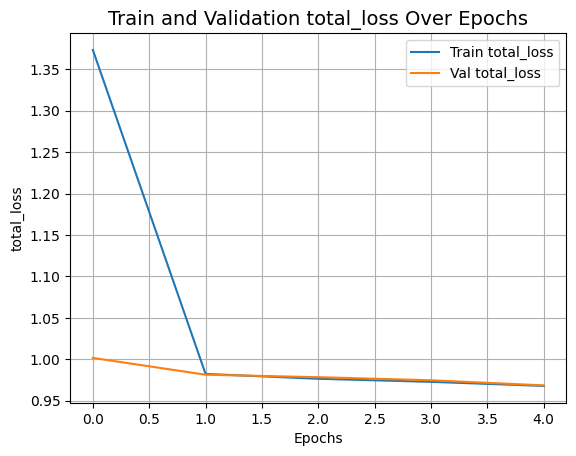

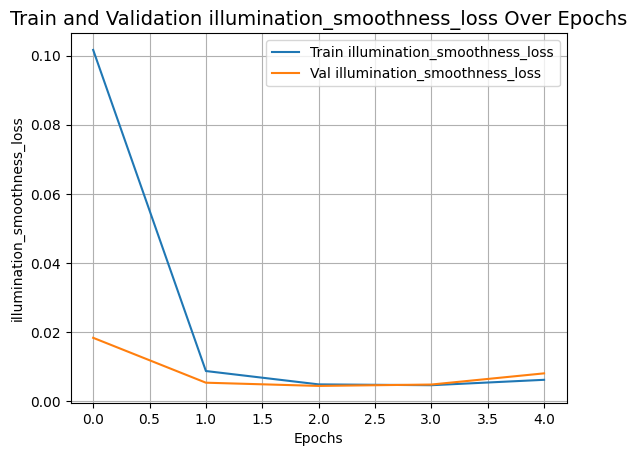

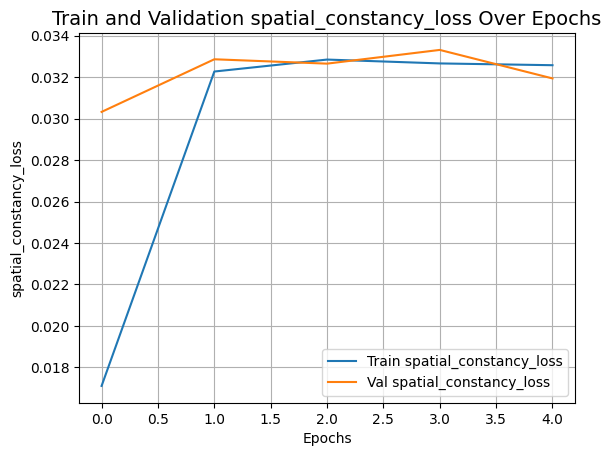

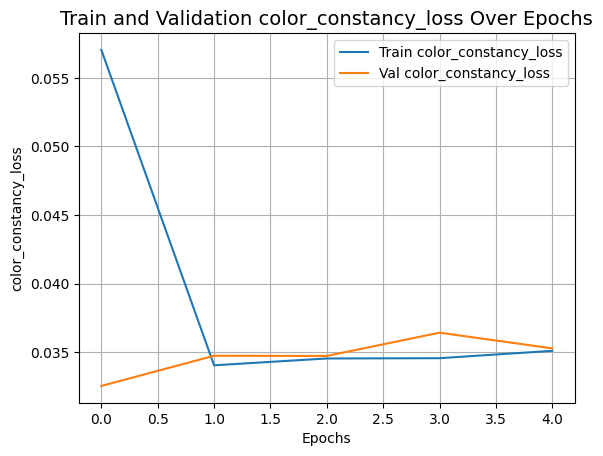

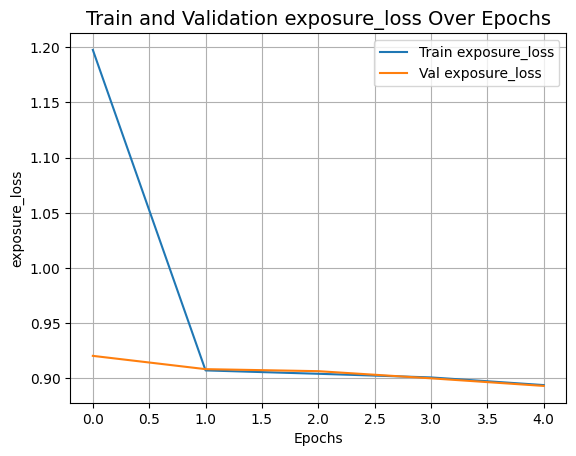

In [7]:
class Config:
    lowlight_images_path = "data/DarkFace/Train/"
    val_images_path = "data/DarkFace/Validation/"
    
    lr = 0.0001
    weight_decay = 0.0001
    grad_clip_norm = 1.0
    num_epochs = 5
    train_batch_size = 12
    val_batch_size = 12
    num_workers = 0
    display_iter = 10
    snapshot_iter = 1
    scale_factor = 1
    
    snapshots_folder = "Zero_DCE++/"
    load_pretrain = False
    pretrain_dir = "Zero_DCE++/Epoch4.pth"

config = Config()

if not os.path.exists(config.snapshots_folder):
    os.mkdir(config.snapshots_folder)

loss_history = train(config)

plot_result(loss_history, "total_loss")
plot_result(loss_history, "illumination_smoothness_loss")
plot_result(loss_history, "spatial_constancy_loss")
plot_result(loss_history, "color_constancy_loss")
plot_result(loss_history, "exposure_loss")


🖼 Procesando: 1259.png


c:\Users\david\miniconda3\envs\Retinex\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


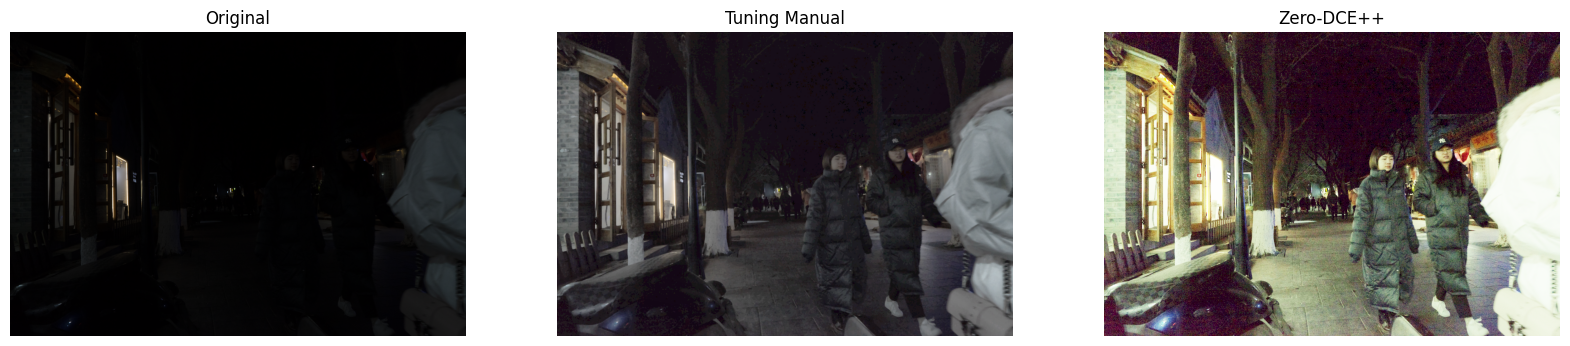

📊 Evaluación: Original
 - BRISQUE: 44.75
 - NIQE: 5.15
 - Entropía: 2.84
 - Contraste RMS: 15.04
------
📊 Evaluación: Tuning Manual
 - BRISQUE: 41.92
 - NIQE: 4.78
 - Entropía: 4.45
 - Contraste RMS: 40.20
------
📊 Evaluación: Zero-DCE++
 - BRISQUE: 38.93
 - NIQE: 3.77
 - Entropía: 4.17
 - Contraste RMS: 80.87
------

🖼 Procesando: 2454.png


📊 Evaluación: Original
 - BRISQUE: 67.16
 - NIQE: 5.75
 - Entropía: 2.09
 - Contraste RMS: 11.86
------
📊 Evaluación: Tuning Manual
 - BRISQUE: 48.05
 - NIQE: 5.10
 - Entropía: 3.84
 - Contraste RMS: 32.56
------
📊 Evaluación: Zero-DCE++
 - BRISQUE: 48.40
 - NIQE: 4.57
 - Entropía: 3.59
 - Contraste RMS: 67.82
------

🖼 Procesando: 2796.png


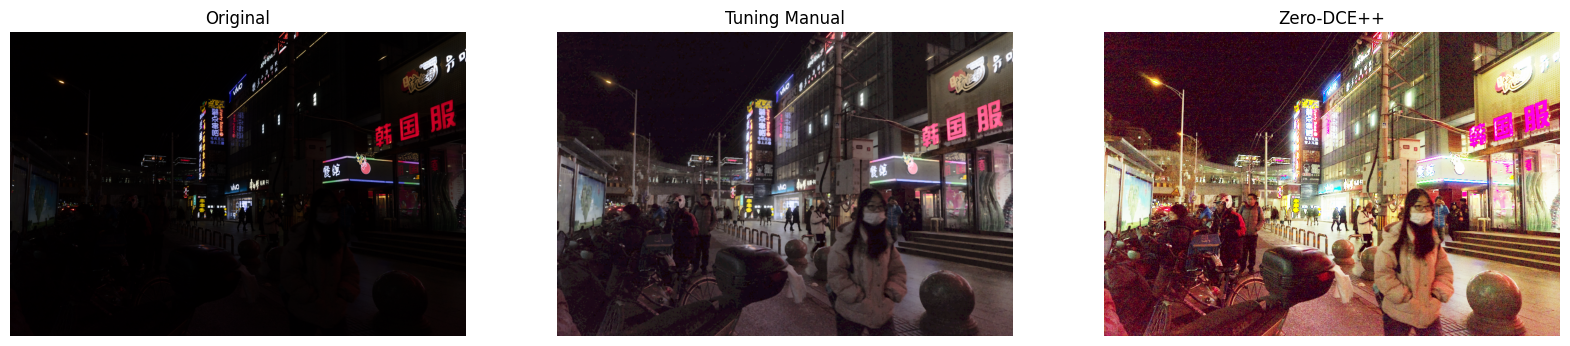

📊 Evaluación: Original
 - BRISQUE: 33.89
 - NIQE: 4.42
 - Entropía: 2.87
 - Contraste RMS: 23.79
------
📊 Evaluación: Tuning Manual
 - BRISQUE: 39.56
 - NIQE: 4.88
 - Entropía: 4.61
 - Contraste RMS: 43.83
------
📊 Evaluación: Zero-DCE++
 - BRISQUE: 39.98
 - NIQE: 3.81
 - Entropía: 4.48
 - Contraste RMS: 74.05
------

🖼 Procesando: 2835.png


📊 Evaluación: Original
 - BRISQUE: 16.22
 - NIQE: 4.02
 - Entropía: 3.43
 - Contraste RMS: 15.94
------
📊 Evaluación: Tuning Manual
 - BRISQUE: 35.48
 - NIQE: 4.37
 - Entropía: 4.91
 - Contraste RMS: 37.83
------
📊 Evaluación: Zero-DCE++
 - BRISQUE: 11.37
 - NIQE: 2.99
 - Entropía: 5.00
 - Contraste RMS: 52.27
------

🖼 Procesando: 3235.png


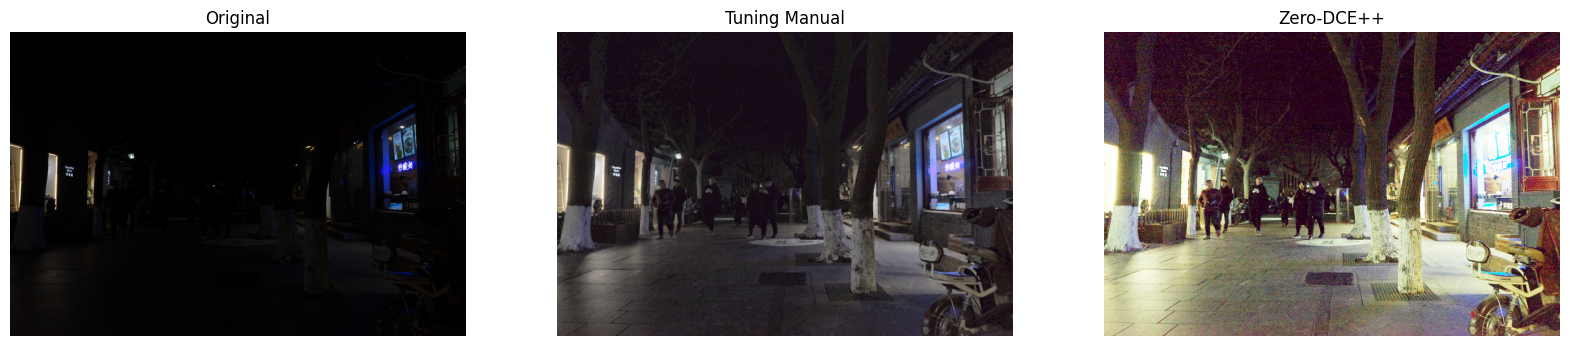

📊 Evaluación: Original
 - BRISQUE: 39.16
 - NIQE: 4.62
 - Entropía: 2.66
 - Contraste RMS: 16.90
------
📊 Evaluación: Tuning Manual
 - BRISQUE: 46.25
 - NIQE: 5.04
 - Entropía: 4.41
 - Contraste RMS: 36.69
------
📊 Evaluación: Zero-DCE++
 - BRISQUE: 42.95
 - NIQE: 3.93
 - Entropía: 4.24
 - Contraste RMS: 72.07
------


In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import cv2
from brisque import BRISQUE
from basicsr.metrics.niqe import calculate_niqe
from scipy.stats import entropy
from basicsr.models import create_model
from basicsr.utils.options import parse

# === Evaluación sin referencia ===
def calculate_rms_contrast(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return np.std(gray)

def calculate_entropy(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    hist_norm = hist_norm[hist_norm > 0]
    return entropy(hist_norm)

def calculate_niqe_wrapped(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY).astype(np.float32)
    if gray.shape[0] < 512 or gray.shape[1] < 512:
        gray = cv2.resize(gray, (512, 512), interpolation=cv2.INTER_CUBIC)
    return calculate_niqe(gray, crop_border=0, input_order='HW', convert_to='gray')

def evaluate_image_quality(name, img_np):
    if img_np.ndim == 2:
        img_np = np.stack([img_np] * 3, axis=-1)  # Asegurando que sea RGB
    elif img_np.shape[2] == 1:
        img_np = np.repeat(img_np, 3, axis=2)  # Convierte de escala de grises a RGB
    elif img_np.shape[2] > 3:
        img_np = img_np[:, :, :3]  # Solo toma los primeros 3 canales (RGB)

    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    pil_image = Image.fromarray(img_np).convert("RGB")  # Asegurando que esté en formato RGB

    if pil_image.size[0] < 256 or pil_image.size[1] < 256:
        pil_image = pil_image.resize((256, 256), Image.BICUBIC)

    brisque_model = BRISQUE()

    print(f"📊 Evaluación: {name}")
    try:
        brisque_score = brisque_model.score(pil_image)  # Asegurando que la imagen se pase en RGB
        print(f" - BRISQUE: {brisque_score:.2f}")
    except Exception as e:
        print(f" - BRISQUE ERROR: {e}")
    
    try:
        niqe_val = float(calculate_niqe_wrapped(img_np))
        print(f" - NIQE: {niqe_val:.2f}")
    except Exception as e:
        print(f" - NIQE ERROR: {e}")

    print(f" - Entropía: {calculate_entropy(img_np):.2f}")
    print(f" - Contraste RMS: {calculate_rms_contrast(img_np):.2f}")
    print("------")

# === Modelo Zero-DCE++ ===
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    model.eval()
    return model

def infer_zero_dce(image_pil, model):
    tensor = transforms.ToTensor()(image_pil).unsqueeze(0).cuda()
    with torch.no_grad():
        result, _ = model(tensor)
    result = result.squeeze(0).permute(1,2,0).cpu().numpy()
    return (np.clip(result * 255, 0, 255)).astype(np.uint8)

# === Ajustes manuales ===
manual_config = {
    "gamma": 0.5,
    "log_transform": False,
    "hist_eq": "clahe",
    "clahe_clip_limit": 2.0,
    "clahe_tile_grid_size": (8, 8),
    "denoise": "median",
    "median_kernel_size": 3,
    "gaussian_kernel_size": (5, 5),
    "gaussian_sigma": 1.0,
    "gray": True
}

def manual_color_tune(image_pil):
    img_rgb = np.array(image_pil)
    gamma = manual_config["gamma"]
    img_float = np.power(img_rgb / 255.0, gamma)
    img_gamma = (img_float * 255).astype(np.uint8)

    img_lab = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)

    if manual_config["hist_eq"] == "clahe":
        clahe = cv2.createCLAHE(
            clipLimit=manual_config["clahe_clip_limit"],
            tileGridSize=manual_config["clahe_tile_grid_size"]
        )
        l_eq = clahe.apply(l)
    elif manual_config["hist_eq"] == "global":
        l_eq = cv2.equalizeHist(l)
    else:
        l_eq = l

    img_lab_eq = cv2.merge((l_eq, a, b))
    img_rgb_eq = cv2.cvtColor(img_lab_eq, cv2.COLOR_LAB2RGB)

    if manual_config["denoise"] == "median":
        img_denoised = cv2.medianBlur(img_rgb_eq, manual_config["median_kernel_size"])
    elif manual_config["denoise"] == "gaussian":
        img_denoised = cv2.GaussianBlur(img_rgb_eq, manual_config["gaussian_kernel_size"], manual_config["gaussian_sigma"])
    else:
        img_denoised = img_rgb_eq

    return img_denoised

# === Visualización ===
def plot_results(images, titles):
    plt.figure(figsize=(20, 8))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# === Cargar modelo Zero-DCE++ ===
scale_factor = 1
DCE_net = enhance_net_nopool(scale_factor).cuda()
DCE_net = load_checkpoint(DCE_net, "Zero_DCE++/Epoch4.pth")

# === Evaluar imágenes ===
test_image_dir = 'data/DarkFace/Test/'
image_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for image_file in image_files[:20]:
    print(f"\n🖼 Procesando: {image_file}")
    image_path = os.path.join(test_image_dir, image_file)
    original_image = Image.open(image_path).convert('RGB')

    original_np = np.array(original_image)
    manual_np = manual_color_tune(original_image)
    enhanced_np = infer_zero_dce(original_image, DCE_net)

    plot_results(
        [original_np, manual_np, enhanced_np],
        ["Original", "Tuning Manual", "Zero-DCE++"]
    )

    evaluate_image_quality("Original", original_np)
    evaluate_image_quality("Tuning Manual", manual_np)
    evaluate_image_quality("Zero-DCE++", enhanced_np)
